In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import multivariate_normal

In [2]:
# load data 
datafile = 'dataCh4_7.mat'
data = scipy.io.loadmat(datafile)

In [27]:
X1, X2, X3 = data['X1'], data['X2'], data['X3']
print('학습 data : ',data['X1'].shape)
print('테스트Data : ',data['X1_test'].shape)

학습 data :  (100, 2)
테스트Data :  (100000, 2)


# Test 데이터에 대한 정보

In [23]:
K = 3

# 평균 계산
m1 = np.mean(data['X1_test'], axis=0)
m2 = np.mean(data['X2_test'], axis=0)
m3 = np.mean(data['X3_test'], axis=0)

# 공분산 계산
cov1 = np.cov(data['X1_test'], rowvar=False)
cov2 = np.cov(data['X2_test'], rowvar=False)
cov3 = np.cov(data['X3_test'], rowvar=False)

# 결과보기
print('='*30)
print(m1,m2,m3,sep='\n')
print('='*30)
print(cov1,cov2,cov3,sep='\n')
print('='*30)

[0.00020396 0.0032293 ]
[3.00059277 3.00222633]
[-0.00413408  3.50057283]
[[ 1.00184935 -0.00423362]
 [-0.00423362  0.99968613]]
[[1.00037915 1.59987734]
 [1.59987734 4.00450063]]
[[2.00602797 0.0073123 ]
 [0.0073123  0.99630563]]


# 표본에 대한 정보

In [29]:
# 표본평균 계산
m1 = np.mean(data['X1'], axis=0)
m2 = np.mean(data['X2'], axis=0)
m3 = np.mean(data['X3'], axis=0)

# 표본공분산 계산
cov1 = np.cov(data['X1'], rowvar=False)
cov2 = np.cov(data['X2'], rowvar=False)
cov3 = np.cov(data['X3'], rowvar=False)

#표본공분산의 평균
cov_mean = (cov1+cov2+cov3)/3

# 결과보기
print('='*30)
print(m1,m2,m3,sep='\n')
print('='*30)
print(cov1,cov2,cov3,sep='\n')
print('='*30)
print(cov_mean)
print('='*30)

[-0.14364878  0.04379621]
[2.94798437 2.81600596]
[0.14632016 3.45188693]
[[1.17320112 0.07187471]
 [0.07187471 1.02321963]]
[[0.99067575 1.59207996]
 [1.59207996 3.86625343]]
[[ 1.77551816 -0.09375714]
 [-0.09375714  1.05701085]]
[[1.31313168 0.52339918]
 [0.52339918 1.98216131]]


In [5]:
#등고선 그리기 함수 정의
def plot_contour(X, mean, cov, label):
    x, y = np.meshgrid(np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100),
                       np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100))
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean=mean, cov=cov)

    plt.contour(x, y, rv.pdf(pos), cmap='viridis', label=label)
    plt.scatter(X[:, 0], X[:, 1], marker='.', label=f'{label} data')

C:\Users\infosec\AppData\Local\Temp\ipykernel_23160\1731474154.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x, y, rv.pdf(pos), cmap='viridis', label=label)


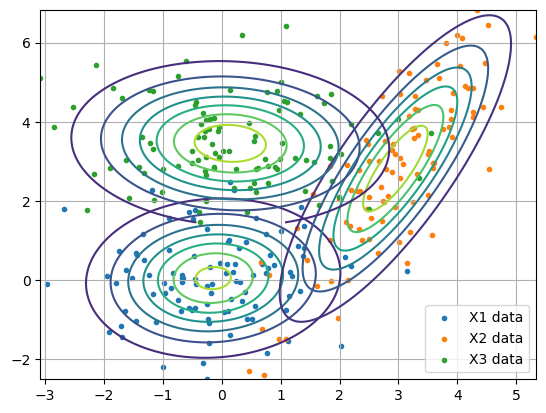

In [15]:
# 등고선 그리기
plot_contour(data['X1'], m1, cov1, 'X1')
plot_contour(data['X2'], m2, cov2, 'X2')
plot_contour(data['X3'], m3, cov3, 'X3')

# 그래프 설정
plt.grid(True)
plt.legend()
plt.show()

In [32]:
# 클래스의 수
K = 3

# 클래스별 표본평균 계산
M = np.vstack([np.mean(data[f'X{i + 1}'], axis=0) for i in range(K)])

# 클래스별 표본공분산 계산
S = np.zeros((2, 2, K))
for i in range(K):
    S[:, :, i] = np.cov(data[f'X{i + 1}'], rowvar=False)

# 클래스별 표본공분산의 평균
smean = np.mean(S, axis=2)

# 학습 데이터 구성
Dtrain = np.vstack([data[f'X{i + 1}'] for i in range(K)])

# 오분류 데이터의 수를 셈
Etrain = np.zeros((3, 1))

# 각 클래스별 데이터의 수
N = data['X1'].shape[0]

# 각 클래스별로 분류 시작
for k in range(1, K + 1):
    X = Dtrain[(k - 1) * N:k * N, :]
    d1 = np.zeros((3, 1))
    d2 = np.zeros((3, 1))
    d3 = np.zeros((3, 1))

    # 각 데이터에 대해 분류 시작
    for i in range(N):
        # 세 개의 판별함수의 값 계산
        # 단위 공분산행렬을 가정한 경우의 판별함수
        d1[:, 0] = np.sum((X[i, :] - M) ** 2, axis=1)
        # 모든 클래스가 동일한 공분산행렬을 가진다고 가정한 경우의 판별함수
        d2[:, 0] = np.sum((X[i, :] - M) @ np.linalg.inv(smean) @ (X[i, :] - M).T, axis=1)
        # 일반적인 공분산행렬을 가정한 경우의 판별함수
        d3[:, 0] = np.sum((X[i, :] - M) @ np.linalg.inv(S[:, :, k - 1]) @ (X[i, :] - M).T, axis=1)

        min1i = np.argmin(d1)  # 각 판별함수 값에 따라 분류
        if min1i != k - 1:
            Etrain[0, 0] += 1
        min2i = np.argmin(d2)
        if min2i != k - 1:
            Etrain[1, 0] += 1
        min3i = np.argmin(d3)
        if min3i != k - 1:
            Etrain[2, 0] += 1

# 오분류율 출력 (학습오차)
Error_rate = Etrain / N
print("Training Error Rate:", Error_rate,sep='\n')

Training Error Rate:
[[0.36]
 [0.4 ]
 [0.3 ]]


In [33]:
# 클래스의 수
K = 3

# 클래스별 표본평균 계산
M = np.vstack([np.mean(data[f'X{i + 1}_test'], axis=0) for i in range(K)])

# 클래스별 표본공분산 계산
S = np.zeros((2, 2, K))
for i in range(K):
    S[:, :, i] = np.cov(data[f'X{i + 1}_test'], rowvar=False)

# 클래스별 표본공분산의 평균
smean = np.mean(S, axis=2)

# 학습 데이터 구성
Dtrain = np.vstack([data[f'X{i + 1}_test'] for i in range(K)])

# 오분류 데이터의 수를 셈
Etrain = np.zeros((3, 1))

# 각 클래스별 데이터의 수
N = data['X1_test'].shape[0]

# 각 클래스별로 분류 시작
for k in range(1, K + 1):
    X = Dtrain[(k - 1) * N:k * N, :]
    d1 = np.zeros((3, 1))
    d2 = np.zeros((3, 1))
    d3 = np.zeros((3, 1))

    # 각 데이터에 대해 분류 시작
    for i in range(N):
        # 세 개의 판별함수의 값 계산
        # 단위 공분산행렬을 가정한 경우의 판별함수
        d1[:, 0] = np.sum((X[i, :] - M) ** 2, axis=1)
        # 모든 클래스가 동일한 공분산행렬을 가진다고 가정한 경우의 판별함수
        d2[:, 0] = np.sum((X[i, :] - M) @ np.linalg.inv(smean) @ (X[i, :] - M).T, axis=1)
        # 일반적인 공분산행렬을 가정한 경우의 판별함수
        d3[:, 0] = np.sum((X[i, :] - M) @ np.linalg.inv(S[:, :, k - 1]) @ (X[i, :] - M).T, axis=1)

        min1i = np.argmin(d1)  # 각 판별함수 값에 따라 분류
        if min1i != k - 1:
            Etrain[0, 0] += 1
        min2i = np.argmin(d2)
        if min2i != k - 1:
            Etrain[1, 0] += 1
        min3i = np.argmin(d3)
        if min3i != k - 1:
            Etrain[2, 0] += 1

# 오분류율 출력 (학습오차)
Error_rate = Etrain / N
print("Test Error Rate:", Error_rate,sep='\n')

Test Error Rate:
[[0.36902]
 [0.36269]
 [0.25136]]


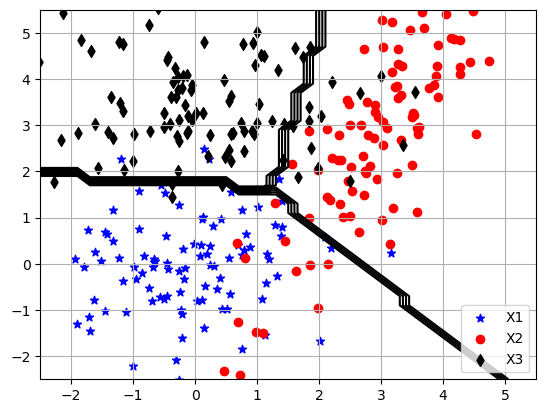

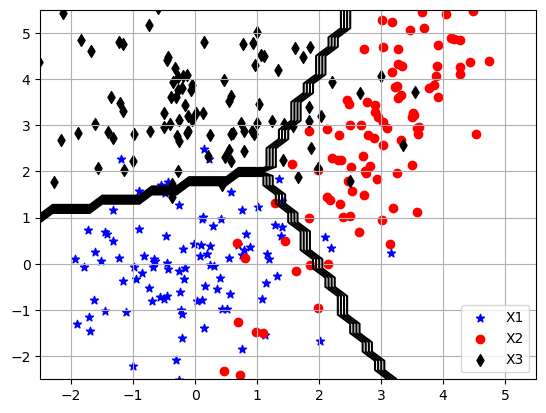

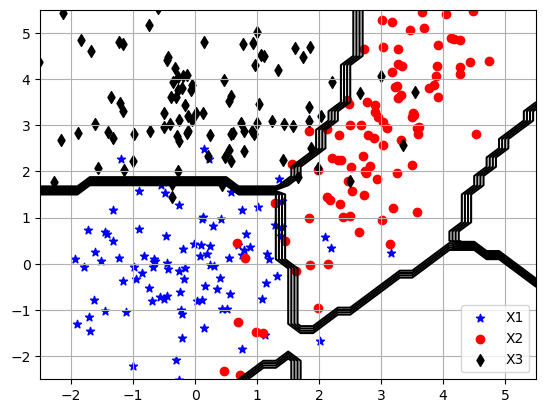

In [14]:
# 클래스별 표본평균 계산
M = np.vstack([np.mean(data[f'X{i + 1}'], axis=0) for i in range(K)])

# 클래스별 표본공분산 계산
S = np.zeros((2, 2, K))
for i in range(K):
    S[:, :, i] = np.cov(data[f'X{i + 1}'], rowvar=False)

smean = np.mean(S, axis=2)  # 클래스별 표본공분산들의 전체 평균

# 2차원 입력 공간을 격자형태로 나누어 입력 행렬을 만듬
x, y = np.meshgrid(np.arange(-2.5, 5.6, 0.2), np.arange(-2.5, 5.6, 0.2))
XY = np.vstack([x.ravel(), y.ravel()]).T

res_classify = np.zeros((3, XY.shape[0]))
# XY의 각 점에 대해 베이지안 분류기의 분류 결과 계산
for i in range(XY.shape[0]):
    for j in range(3):
        d1[j, 0] = np.sum((XY[i, :] - M[j, :]) ** 2)
        d2[j, 0] = np.sum((XY[i, :] - M[j, :]) @ np.linalg.inv(smean) @ (XY[i, :] - M[j, :]).T)
        d3[j, 0] = np.sum((XY[i, :] - M[j, :]) @ np.linalg.inv(S[:, :, j]) @ (XY[i, :] - M[j, :]).T)

    res_classify[0, i] = np.argmin(d1)
    res_classify[1, i] = np.argmin(d2)
    res_classify[2, i] = np.argmin(d3)

# 등고선 그리기
for m in range(3):
    plt.figure(m + 1)
    plt.axis([-2.5, 5.5, -2.5, 5.5])
    plt.grid(True)
    plt.scatter(data['X1'][:, 0], data['X1'][:, 1], marker='*', label='X1', c='b')
    plt.scatter(data['X2'][:, 0], data['X2'][:, 1], marker='o', label='X2', c='r')
    plt.scatter(data['X3'][:, 0], data['X3'][:, 1], marker='d', label='X3', c='k')

    res = res_classify[m, :].reshape(x.shape)

    # levels 매개변수를 추가하여 등고선 레벨을 명시적으로 지정
    #plt.contour(x, y, res, levels=[0.5, 1.5], colors='black', linestyles='dashed')
    plt.contour(x, y, res, colors='black')
    plt.legend()
    plt.show()
